### Rule-based model
Valence Aware Dictionary and sEntiment Reasoner (VADER)
  - Valence score: emotional measurement
  - Lexicon: average of 10 independent human raters [-4, +4]
  - Specialized for Social media
  - Compound: Summing words valence scores; adjusted to rules; normalized between -1 & 1
  - [Paper](https://ojs.aaai.org/index.php/ICWSM/article/view/14550) & [git repository](https://github.com/cjhutto/vaderSentiment/)

In [1]:

import json

import pandas as pd
from IPython.display import display

# ruff: noqa: E402
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from jupyter_utils import JupyterUtils as JU

DO_PROCESS = False
ju = JU()

# Generated with help of LLMs
# E.g.: cliche, shallow, atmospheric, cringe, wooden, rushed
with open("./movie_lexicon.json", "r", encoding="utf-8") as f:
    extra_lexicon = json.load(f)

analyzer = SentimentIntensityAnalyzer()
analyzer.lexicon.update(extra_lexicon)


sentences = [
    "I like this movie.",
    "I love this movie.",  # Different weights on words
    "I love this movie!",  # Punctuation & emoticons
    "I love this movie! 😍",  # Emojis
    "I LOVE this movie!",  # Capitalization emphasis
    "I really love this movie!!!",  # Repeated punctuation & intensifier
    "I don't love this movie.",  # Negation with contraction
    "This movie is okay.",  # Neutral sentiment
]

results = []

for sentence in sentences:
    score = analyzer.polarity_scores(sentence)
    results.append(
        {
            "Sentence": sentence,
            "Compound Score": score["compound"],
            "Positive": score["pos"],
            "Neutral": score["neu"],
            "Negative": score["neg"],
        }
    )

df = pd.DataFrame(results)
df

,Sentence,Compound Score,Positive,Neutral,Negative
0,I like this movie.,0.3612,0.455,0.545,0.000
1,I love this movie.,0.6369,0.583,0.417,0.000
2,I love this movie!,0.6696,0.600,0.400,0.000
3,I love this movie! 😍,0.8172,0.555,0.445,0.000
4,I LOVE this movie!,0.7371,0.635,0.365,0.000
5,I really love this movie!!!,0.7483,0.573,0.427,0.000
6,I don't love this movie.,-0.5216,0.000,0.543,0.457
7,This movie is okay.,0.2263,0.388,0.612,0.000


In [2]:
df_reviews = pd.read_csv("./data/raw/rotten_tomatoes_critic_reviews.csv")
df_movies = pd.read_csv("./data/raw/rotten_tomatoes_movies.csv")
# Remove reviews with null scores or content
df_reviews = df_reviews.dropna(subset=["review_score", "review_content"])

In [4]:
from fractions import Fraction

import numpy as np

# Normalize scores to 0-1
GRADES = {
    "A+": 12,
    "A": 11,
    "A−": 10,
    "B+": 9,
    "B": 8,
    "B−": 7,
    "C+": 6,
    "C": 5,
    "C−": 4,
    "D+": 3,
    "D": 2,
    "D−": 1,
    "F": 0,
}


def normalize_score(score):
    """Transform score to [0, 1]"""
    if "/" in score:
        try:
            num, den = score.split("/")
            num = float(Fraction(num))
            den = float(Fraction(den))
            if den > 0:
                return num / den
            else:
                return np.nan
        except Exception:
            return np.nan

    # Remove white spaces
    score = score.replace(" ", "")

    # Letter grade
    if score in GRADES:
        return GRADES[score] / 12

    # Some values are numeric without "/", ignore them
    return np.nan


df_reviews["score_norm"] = df_reviews["review_score"].apply(normalize_score)

df_reviews = df_reviews.dropna(subset=["score_norm"])

# Filter out erranous scores (e.g. 8/5)
df_reviews = df_reviews[df_reviews["score_norm"] <= 1]

# Transform to +ve -ve scores
df_reviews["polarity"] = df_reviews["score_norm"].apply(
    lambda x: 1 if x >= 0.7 else -1 if x <= 0.4 else 0
)

df_reviews = df_reviews[df_reviews["polarity"] != 0]

In [6]:
ju.freq(df_reviews, "polarity")

,count,percentage,cumulative
polarity,,,
1,325971,70.06,70.06
-1,139296,29.94,100.00


In [24]:
df_reviews = pd.read_csv("./data/processed/rotten_tomatoes_critic_reviews.csv")

In [29]:

n = 50000  # number you want

pos_samples = df_reviews[df_reviews["polarity"] == 1].sample(n, random_state=42)
neg_samples = df_reviews[df_reviews["polarity"] == 0].sample(n, random_state=42)

df_reviews_ = pd.concat([pos_samples, neg_samples], ignore_index=True)

In [4]:
%%execute_if DO_PROCESS
import spacy
from spellchecker import SpellChecker

nlp = spacy.load("en_core_web_sm")
spell = SpellChecker()


def clean_text(text: str) -> str:
    """Correct typos"""
    tokens = nlp(text)
    cleaned_tokens = []

    for token in tokens:
        if token.is_alpha:
            # Remove 3 or more repeated characters, to improve chances of correcting words
            word = re.sub(r"(.)\1{2,}", r"\1\1", token.text)
            corrected = spell.correction(word)
            corrected = corrected if corrected else word
            cleaned_tokens.append(corrected + token.whitespace_)
        else:
            cleaned_tokens.append(token.text_with_ws)

    return "".join(cleaned_tokens)


df_reviews["clean_review"] = df_reviews["review_content"].progress_apply(clean_text)

df_reviews.to_csv(
    "./data/processed/rotten_tomatoes_critic_reviews_rule_based.csv", index=False
)

UsageError: Cell magic `%%execute_if` not found.


In [7]:

df_ = pd.merge(
    df_movies[["movie_title", "rotten_tomatoes_link"]],
    df_reviews,
    left_on="rotten_tomatoes_link",
    right_on="rotten_tomatoes_link",
    how="inner",
)

import json
import re

In [8]:
from collections import Counter

from tqdm import tqdm

tqdm.pandas()  # enables df.progress_apply()


def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())


# Remove full movie title from text
def remove_movie_title(text, title):
    # Case-insensitive removal
    return re.sub(re.escape(title), "", text, flags=re.IGNORECASE).strip()


def vader_sentiment_with_word_counts(text, title):
    clean_text = remove_movie_title(text, title)
    words = tokenize(clean_text)
    pos_counter, neg_counter = Counter(), Counter()
    for word in words:
        if word in analyzer.lexicon:
            score = analyzer.lexicon[word]
            if score > 0:
                pos_counter[word] += 1
            elif score < 0:
                neg_counter[word] += 1
    scores = analyzer.polarity_scores(text)
    return pd.Series(
        {
            "compound": scores["compound"],
            "pos_words": pos_counter,
            "neg_words": neg_counter,
        }
    )


df_ = df_.dropna(subset="review_content")
# Apply per review
df_sentiment = df_.join(
    df_.progress_apply(
        lambda x: vader_sentiment_with_word_counts(
            x["review_content"], x["movie_title"]
        ),
        axis=1,
    )
)

100%|██████████| 465218/465218 [03:07<00:00, 2486.28it/s]


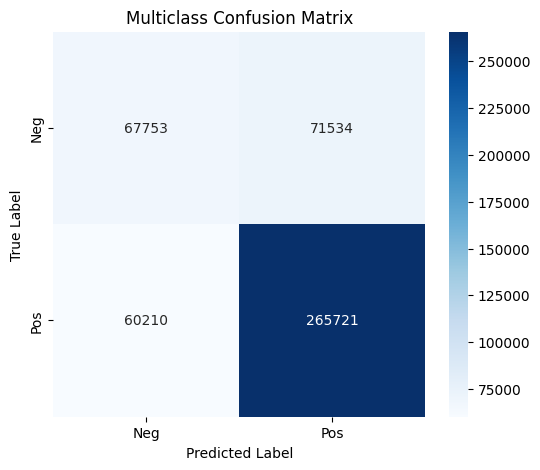

Accuracy: 0.72
Precision: 0.71
Recall:    0.72
F1-score:  0.71


In [15]:
# For neutral
# df_sentiment["pred_polarity"] = df_sentiment["compound"].apply(
#     lambda x: 1 if x >= 0.1 else -1 if x <= -0.1 else 0
# )
df_sentiment["pred_polarity"] = df_sentiment["compound"].apply(
    lambda x: 1 if x >= 0 else -1
)


def merge_counters(counters):
    result = Counter()
    for c in counters:
        result.update(c)
    return result.most_common(5)


agg_df = (
    df_sentiment.groupby("movie_title")
    .agg(
        num_reviews=("review_content", "count"),
        mean_compound=("compound", "mean"),
        pos_words=("pos_words", merge_counters),
        neg_words=("neg_words", merge_counters),
        mean_polarity=("polarity", "mean"),
        mean_pred_polarity=("pred_polarity", "mean"),
        accuracy_polarity=(
            "pred_polarity",
            lambda x: (x == df_sentiment.loc[x.index, "polarity"]).mean(),
        ),  # per-movie accuracy
    )
    .reset_index()
)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

df_sentiment = df_sentiment.dropna(subset=["pred_polarity"])
# Overall metrics
y_true = df_sentiment["polarity"]
y_pred = df_sentiment["pred_polarity"]

accuracy = (y_true == y_pred).mean()
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

# Heatmap for confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Neg", "Pos"],
    yticklabels=["Neg", "Pos"],
)
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-score:  {f1:.2f}")

In [11]:
with ju.full_display():
    display(
        agg_df.sort_values(by="num_reviews", ascending=False)
        .reset_index(drop=True)
        .head()
    )

,movie_title,num_reviews,mean_compound,pos_words,neg_words,mean_polarity,mean_pred_polarity,accuracy_polarity
0,Star Wars: Episode VII - The Force Awakens,512,0.408897,"[(original, 58), (good, 46), (fun, 40), (like, 40), (great, 38)]","[(wars, 194), (no, 28), (hard, 12), (strikes, 10), (battle, 6)]",0.976562,0.695312,0.851562
1,Star Wars: The Last Jedi,504,0.275631,"[(best, 52), (like, 36), (good, 32), (great, 26), (hope, 22)]","[(wars, 164), (no, 28), (strikes, 20), (leave, 8), (lost, 6)]",0.952381,0.420635,0.710317
2,Spider-Man: Into the Spider-Verse,462,0.596438,"[(best, 80), (like, 36), (fun, 34), (marvel, 32), (fresh, 28)]","[(no, 10), (fatigue, 4), (tired, 4), (hard, 4), (doubt, 4)]",0.965368,0.930736,0.956710
3,Star Trek,458,0.477947,"[(fun, 34), (entertaining, 28), (great, 26), (exciting, 26), (boldly, 20)]","[(no, 22), (hard, 10), (leave, 8), (wars, 8), (die, 6)]",0.982533,0.799127,0.899563
4,Rogue One: A Star Wars Story,454,0.147885,"[(best, 42), (like, 30), (well, 28), (fan, 22), (good, 20)]","[(wars, 208), (war, 18), (battle, 16), (strikes, 14), (no, 10)]",0.876652,0.233480,0.625551


In [14]:
with ju.full_display():
    display(
        df_sentiment[df_sentiment["polarity"] != df_sentiment["pred_polarity"]][
            [
                "movie_title",
                "review_score",
                "review_content",
                "score_norm",
                "polarity",
                "compound",
                "pos_words",
                "neg_words",
                "pred_polarity",
            ]
        ].head()
    )

,movie_title,review_score,review_content,score_norm,polarity,compound,pos_words,neg_words,pred_polarity
6,Percy Jackson & the Olympians: The Lightning Thief,2/5,"Although the standard allegorical bases for mythical-quest movies are dutifully covered, the obvious similarity of Percy Jackson to the Harry Potter movies inevitably makes it feel somewhat secondhand.",0.40,-1,0.0000,{},{},1
10,Percy Jackson & the Olympians: The Lightning Thief,2/5,"The disappearance of lightning simply is not interesting, and Percy Jackson and the Olympians sounds more like a '70s funk band than a kid's series.",0.40,-1,0.1368,"{'interesting': 1, 'like': 1}",{},1
12,Percy Jackson & the Olympians: The Lightning Thief,1/4,It raises issues it doesn't have the balls to resolve by placing them in a context it doesn't have the brains to exploit.,0.25,-1,0.2960,{'resolve': 1},{'exploit': 1},1
13,Percy Jackson & the Olympians: The Lightning Thief,1/4,Whew boy.,0.25,-1,0.0000,{},{},1
17,Percy Jackson & the Olympians: The Lightning Thief,2/5,Too scary for younger fans of the popular book.,0.40,-1,0.7003,"{'scary': 1, 'popular': 1}",{},1


### Limitations

  - Doesn't understand context, idioms, sarcasm, irony, etc.
  - Intensive manual labor
  - Unscalable with many rules